In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
import glob as gb
import pandas as pd
import seaborn as sns
import matplotlib.image as mpimg
from tqdm import tqdm
from PIL import Image

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [10]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.optimizers import Adam

In [11]:
from keras.applications import DenseNet121
from keras.applications import ResNet50V2
from keras.applications import ResNet152V2
from keras.applications import InceptionV3
from keras.applications import Xception

In [12]:
train_path="/content/drive/MyDrive/image_classification/train"
test_path = "/content/drive/MyDrive/image_classification/test"

In [13]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255,                # Rescale pixel values to [0, 1]
    rotation_range=20,              # Random rotation within 20 degrees
    width_shift_range=0.2,          # Random horizontal shift by 20% of image width
    height_shift_range=0.2,         # Random vertical shift by 20% of image height
    horizontal_flip=True,           # Random horizontal flipping
    fill_mode='nearest'             # Fill mode for new pixels after shifts/rotations
)

In [25]:
batch_size = 32
img_height = 180
img_width = 180

In [28]:
train_generator = train_datagen.flow_from_directory(
    train_path,                     # Path to the training data
    target_size=(img_height, img_width),  # Resize images to this size
    batch_size=batch_size,           # Number of images in each batch
    seed=32,                         # Optional: Set a random seed for shuffling
    shuffle=True,                    # Shuffle the data during training
    class_mode='categorical'        # Mode for class labels (categorical for one-hot encoding)
)

Found 592 images belonging to 2 classes.


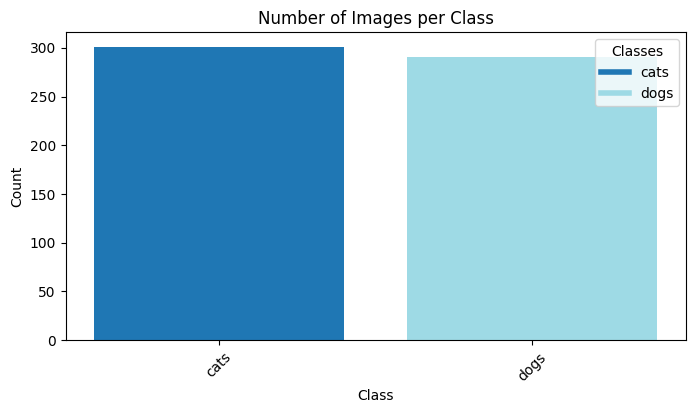

In [29]:
# Get the class labels
class_labels = list(train_generator.class_indices.keys())

# Calculate the count of images per class
class_counts = {label: 0 for label in class_labels}

for i in range(len(train_generator)):
    batch_data, batch_labels = train_generator[i]
    for j in range(len(batch_data)):
        class_idx = int(batch_labels[j].argmax())
        class_label = class_labels[class_idx]
        class_counts[class_label] += 1

# Define unique colors for each class
class_colors = plt.cm.tab20(np.linspace(0, 1, len(class_labels)))

# Create a bar chart with different colors for each class
plt.figure(figsize=(8, 4))
bars = plt.bar(class_counts.keys(), class_counts.values(), color=class_colors)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Number of Images per Class')
plt.xticks(rotation=45)

# Add a legend for class colors
legend_labels = [plt.Line2D([0], [0], color=class_colors[i], lw=4, label=class_labels[i]) for i in range(len(class_labels))]
plt.legend(handles=legend_labels, title="Classes")

plt.show()

In [30]:
# data augmentation for testing
test_datagen = ImageDataGenerator(rescale=1.0/255)  # Rescale pixel values to [0, 1]

In [32]:
# Create a generator for testing data
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_height, img_width),  # Resize images to this size
    batch_size = batch_size,
    class_mode='categorical')

Found 140 images belonging to 2 classes.


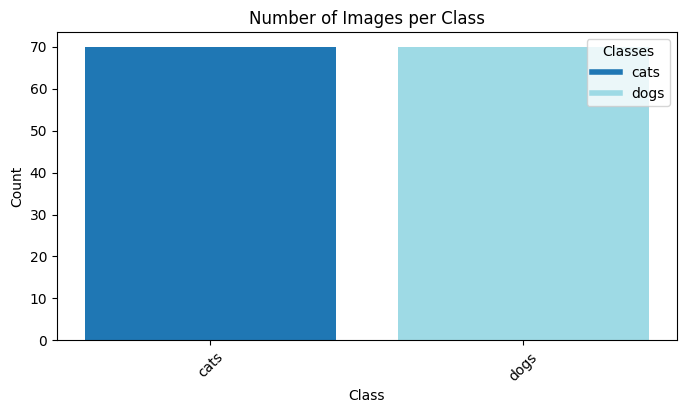

In [33]:
# Get the class labels
class_labels = list(test_generator.class_indices.keys())

# Calculate the count of images per class
class_counts = {label: 0 for label in class_labels}

for i in range(len(test_generator)):
    batch_data, batch_labels = test_generator[i]
    for j in range(len(batch_data)):
        class_idx = int(batch_labels[j].argmax())
        class_label = class_labels[class_idx]
        class_counts[class_label] += 1

# Define unique colors for each class
class_colors = plt.cm.tab20(np.linspace(0, 1, len(class_labels)))

# Create a bar chart with different colors for each class
plt.figure(figsize=(8, 4))
bars = plt.bar(class_counts.keys(), class_counts.values(), color=class_colors)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Number of Images per Class')
plt.xticks(rotation=45)

# Add a legend for class colors
legend_labels = [plt.Line2D([0], [0], color=class_colors[i], lw=4, label=class_labels[i]) for i in range(len(class_labels))]
plt.legend(handles=legend_labels, title="Classes")

plt.show()

In [34]:
def Show_Images(target_gen):
    # Get a batch of images and labels
    batch_images, batch_labels = next(target_gen)

    # Get class labels
    class_labels = list(target_gen.class_indices.keys())

    # Display images with labels
    plt.figure(figsize=(20, 20))
    for n , i in enumerate(list(np.random.randint(0,len(batch_images),16))):
        plt.subplot(4, 4, n + 1)
        plt.imshow(batch_images[i])
        plt.title(class_labels[np.argmax(batch_labels[i])])  # Display the class label
        plt.axis('off')
    plt.show()

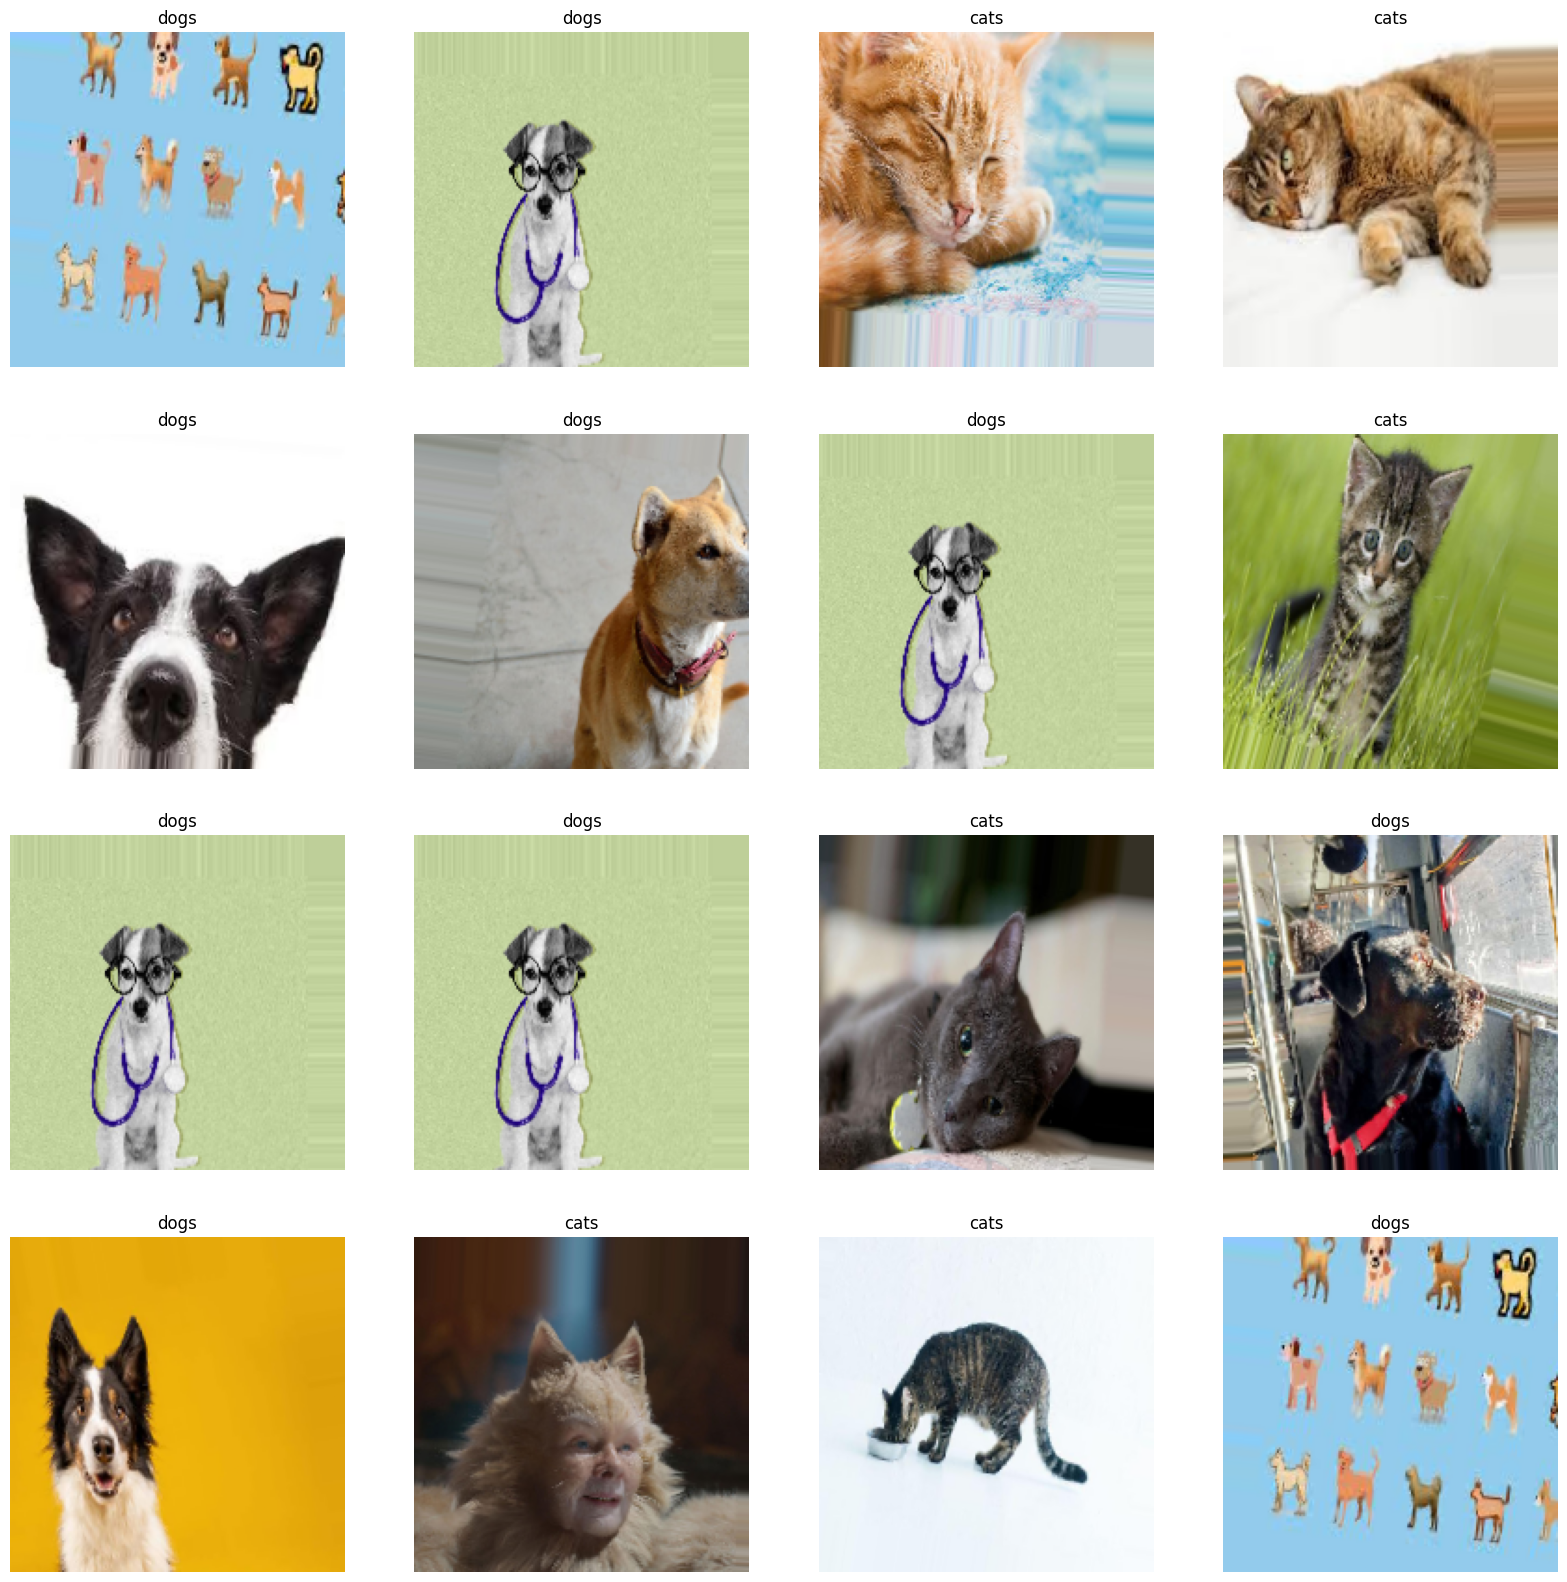

In [35]:
Show_Images(train_generator)

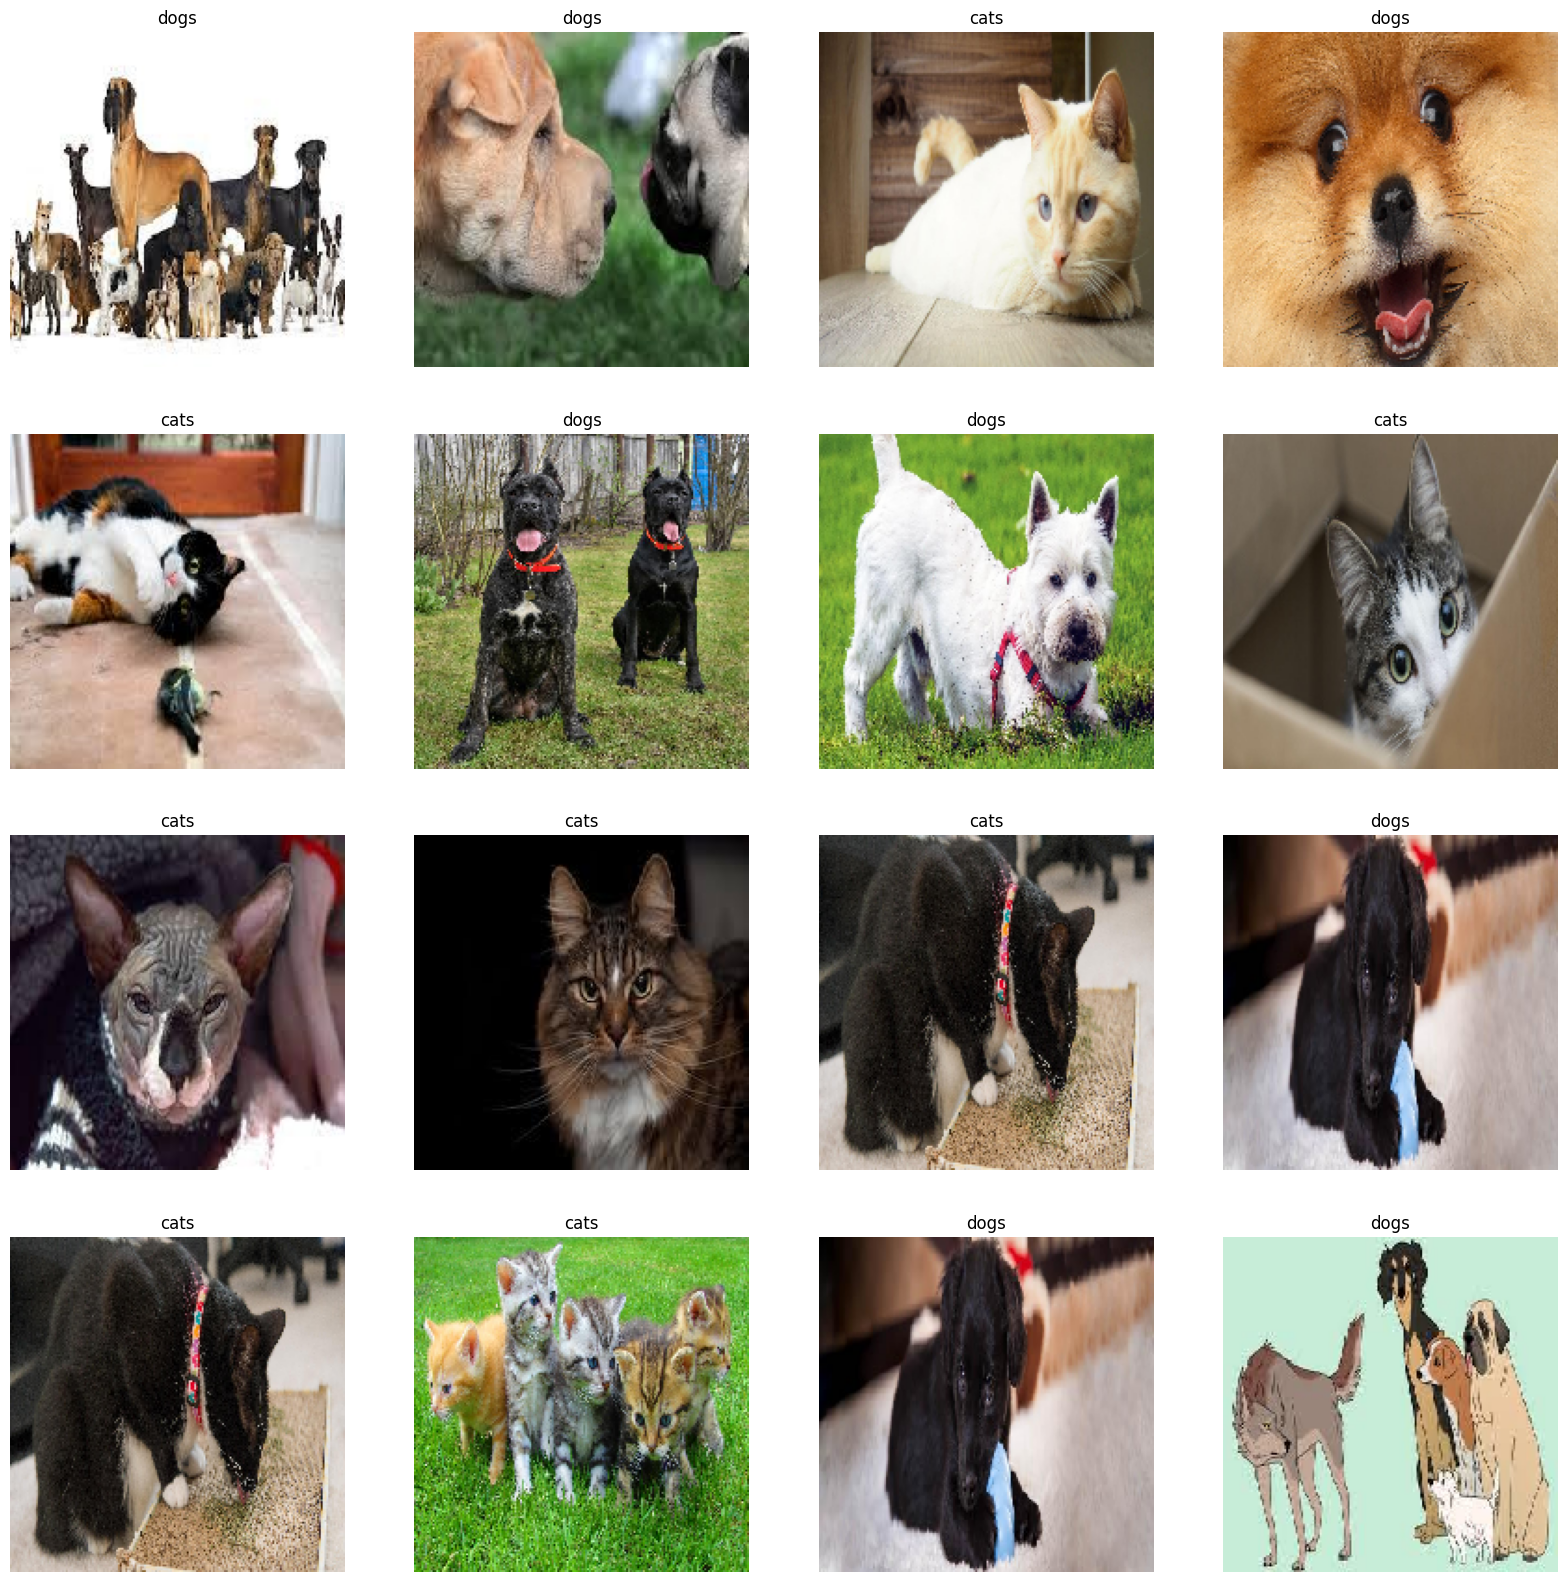

In [36]:
Show_Images(test_generator)

In [37]:
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [38]:
# Configure the learning rate reduction callback
learning_rate_reduce = ReduceLROnPlateau(
    monitor='val_acc',   # Metric to monitor for changes (usually validation accuracy)
    patience=5,          # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,           # Verbosity mode (0: silent, 1: update messages)
    factor=0.5,          # Factor by which the learning rate will be reduced (e.g., 0.5 means halving)
    min_lr=0.00001       # Lower bound for the learning rate (it won't go below this value)
)

In [45]:
from tensorflow.keras import optimizers

# Create a learning rate schedule using Exponential Decay
learning_rate_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,  # Initial learning rate for training
    decay_steps=1000,            # Number of steps before decaying the learning rate
    decay_rate=0.5,              # Rate at which the learning rate decreases
)

# learning_rate = initial_learning_rate * decay_rate ^ (global_step / decay_steps)


In [46]:
from keras.callbacks import LearningRateScheduler

# Create a Learning Rate Scheduler callback using a pre-defined schedule
lr_callback = LearningRateScheduler(learning_rate_schedule)
callback=[ lr_callback , learning_rate_reduce ,early_stopping ]

In [47]:
# Collect all TL models
TL_Models =[
    ResNet50V2(input_shape=(img_height, img_width, 3), weights='imagenet', include_top=False),
    ResNet152V2(input_shape=(img_height, img_width, 3), weights='imagenet', include_top=False),
    InceptionV3(input_shape=(img_height, img_width, 3), weights='imagenet', include_top=False),
    Xception(input_shape=(img_height, img_width, 3), weights='imagenet', include_top=False),
    DenseNet121( input_shape=(img_height, img_width, 3) ,weights='imagenet', include_top=False),
]

# Define all the TL models names. This will be later used during visualization
TL_Models_NAMES = [
    'ResNet50V2',
    'ResNet152V2',
    'InceptionV3',
    'Xception',
    'DenseNet121',
]

# Freeze the weights of all the TL models
for tl_model in TL_Models:
    tl_model.trainable = False

In [48]:
# Create variables to collect images and labels
subset_images = []
subset_labels = []

# Set the desired number of images you want in the subset
desired_count = 1000

# Loop through the generator until you have collected the desired number of images
for i in range(desired_count):
    # Generate a batch of data (images and labels)
    batch = train_generator.next()
    images, labels = batch
    subset_images.extend(images)
    subset_labels.extend(labels)

    # Check if you've collected enough images
    if len(subset_images) >= desired_count:
        break

# Convert the collected images and labels to numpy arrays
X_sub = np.array(subset_images)
y_sub = np.array(subset_labels)

In [ ]:
# Initialize an empty list to hold the histories of each TL_models architecture.
HISTORIES = []

# Loop over every backbone in the BACKBONES list.
for tl_model in tqdm(TL_Models, desc="Training Tl Models"):

    # Create the simplest model architecture using the current backbone.
    model = keras.Sequential([
        tl_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        layers.Dense(2, activation='softmax')
    ])

    # Compile the model with the specified loss function, optimizer, and metrics.
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate = learning_rate_schedule),
        metrics='accuracy'
    )

    # Train the model on a subset of the training data.
    history = model.fit(
        X_sub, y_sub,
        epochs=10,
        validation_split=0.2,
        batch_size=batch_size
    )

    # Store the history of the trained model.
    HISTORIES.append(history.history)

Training Tl Models:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/10
26/26 [==============================] - 169s 6s/step - loss: 0.5994 - accuracy: 0.8660 - val_loss: 0.1819 - val_accuracy: 0.9406
Epoch 2/10
26/26 [==============================] - 151s 6s/step - loss: 0.3080 - accuracy: 0.9380 - val_loss: 0.3366 - val_accuracy: 0.9307
Epoch 3/10
26/26 [==============================] - 122s 5s/step - loss: 0.2124 - accuracy: 0.9479 - val_loss: 0.3022 - val_accuracy: 0.9505
Epoch 4/10
26/26 [==============================] - 138s 5s/step - loss: 0.2140 - accuracy: 0.9628 - val_loss: 0.2592 - val_accuracy: 0.9554
Epoch 5/10
26/26 [==============================] - 123s 5s/step - loss: 0.1876 - accuracy: 0.9578 - val_loss: 0.4161 - val_accuracy: 0.9208
Epoch 6/10
26/26 [==============================] - 140s 5s/step - loss: 0.1963 - accuracy: 0.9640 - val_loss: 0.2342 - val_accuracy: 0.9703
Epoch 7/10
26/26 [==============================] - 138s 5s/step - loss: 0.0999 - accuracy: 0.9739 - val_loss: 0.4322 - val_accuracy: 0.9505
Epoch 8/10
26

Training Tl Models:  20%|██        | 1/5 [23:31<1:34:04, 1411.24s/it]

Epoch 1/10
26/26 [==============================] - 385s 15s/step - loss: 0.7725 - accuracy: 0.8400 - val_loss: 0.6443 - val_accuracy: 0.9059
Epoch 2/10
26/26 [==============================] - 365s 14s/step - loss: 0.2986 - accuracy: 0.9442 - val_loss: 0.3380 - val_accuracy: 0.9505
Epoch 3/10
26/26 [==============================] - 350s 14s/step - loss: 0.2450 - accuracy: 0.9665 - val_loss: 0.3462 - val_accuracy: 0.9554
Epoch 4/10
26/26 [==============================] - 365s 14s/step - loss: 0.1583 - accuracy: 0.9690 - val_loss: 0.3249 - val_accuracy: 0.9703
Epoch 5/10
26/26 [==============================] - 364s 14s/step - loss: 0.1482 - accuracy: 0.9665 - val_loss: 0.2932 - val_accuracy: 0.9653
Epoch 6/10
26/26 [==============================] - 372s 14s/step - loss: 0.1208 - accuracy: 0.9727 - val_loss: 0.3312 - val_accuracy: 0.9604
Epoch 7/10
20/26 [======================>.......] - ETA: 1:08 - loss: 0.1411 - accuracy: 0.9750

In [ ]:
import matplotlib.pyplot as plt

# Define the metrics to plot (e.g., 'accuracy' and 'loss')
metrics_to_plot = ['accuracy', 'loss']

# Create subplots for each metric
fig, axes = plt.subplots(len(metrics_to_plot), 1, figsize=(10, 6))

for i, metric in enumerate(metrics_to_plot):
    plt.subplot(2, 1, i+1)  # Create subplots for each metric
    for idx, history in enumerate(HISTORIES):
        plt.plot(history[metric], label=TL_Models_NAMES[idx])
    plt.title(f'Training and Validation {metric}')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

In [ ]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
model = tf.keras.models.Sequential([
    base_model,

    layers.Flatten(),

    layers.Dense(256,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2,activation='softmax'),
])

model.summary()

In [ ]:
optimizer = optimizers.Adam(learning_rate=learning_rate_schedule)

In [ ]:
model.compile(optimizer=optimizer,
             loss="categorical_crossentropy",
              metrics=['accuracy']
             )

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[callback]
)

In [ ]:
# Evaluate on test dataset
score = model.evaluate(test_generator, verbose=False)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
# Accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()


In [ ]:
# Loss
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [ ]:
# Confusion Matrix
import itertools

# Make predictions on the test data
predictions = model.predict(test_generator)

# Convert probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get true labels from the test_generator
true_labels = test_generator.classes

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Define class names (assuming you have class_names defined)
class_names = test_generator.class_indices.keys()

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion Matrix", cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cm, classes=class_names, title="Confusion Matrix")
plt.show()

In [ ]:
# Collect true labels and model predictions
true_labels = []
predicted_labels = []
class_names = test_generator.class_indices.keys()
class_names = list(class_names)
num_batches = len(test_generator)
for i in range(10):
    x_batch, y_batch = test_generator[i]
    predictions = model.predict(x_batch)
    true_labels.extend(np.argmax(y_batch, axis=1))  # Convert one-hot encoded labels to class indices
    predicted_labels.extend(np.argmax(predictions, axis=1))


true_class_labels = [class_names[i] for i in true_labels]
predicted_class_labels = [class_names[i] for i in predicted_labels]

# Plot true labels and predicted labels
plt.figure(figsize=(10, 5))
num_samples_to_display = min(10, len(x_batch))  # Display up to 10 samples or less if available
for i in range(num_samples_to_display):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_batch[i])
    plt.title(f'True: {true_class_labels[i]}\nPredicted: {predicted_class_labels[i]}', fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()